<a href="https://colab.research.google.com/github/adarsh-meher/MH--Chartbuster-Prediction/blob/master/Analysis_Codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
! pip install tpot
! pip install deap
! pip install category_encoders
! pip install h2o


In [15]:
! git clone https://github.com/adarsh-meher/MH--Chartbuster-Prediction.git

Cloning into 'MH--Chartbuster-Prediction'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [0]:
import os
os.chdir('/content/MH--Chartbuster-Prediction')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
import spacy as sc
import hyperopt as hopt
import tpot
import category_encoders
import h2o
import time
from datetime import datetime

In [0]:
train = pd.read_csv('Data_Train.csv')
test = pd.read_csv('Data_Test.csv')

In [18]:
train.info()
#### No nulls. 7 object columns and rest integer. The target column is integer.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78458 entries, 0 to 78457
Data columns (total 11 columns):
Unique_ID     78458 non-null int64
Name          78458 non-null object
Genre         78458 non-null object
Country       78458 non-null object
Song_Name     78457 non-null object
Timestamp     78458 non-null object
Views         78458 non-null int64
Comments      78458 non-null int64
Likes         78458 non-null object
Popularity    78458 non-null object
Followers     78458 non-null int64
dtypes: int64(4), object(7)
memory usage: 6.6+ MB


In [19]:
test.info()
### No nulls.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19615 entries, 0 to 19614
Data columns (total 10 columns):
Unique_ID     19615 non-null int64
Name          19615 non-null object
Genre         19615 non-null object
Country       19615 non-null object
Song_Name     19615 non-null object
Timestamp     19615 non-null object
Comments      19615 non-null int64
Likes         19615 non-null object
Popularity    19615 non-null object
Followers     19615 non-null int64
dtypes: int64(3), object(7)
memory usage: 1.5+ MB


In [20]:
train.head()

,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers
0,413890,Hardstyle,danceedm,AU,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45.000000,14017,4,499,97,119563
1,249453,Dj Aladdin,danceedm,AU,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52.000000,1918,17,49,17,2141
2,681116,Maxximize On Air,danceedm,AU,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59.000000,9668,11,312,91,22248
3,387253,GR6 EXPLODE,rbsoul,AU,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03.000000,113036,2,"2,400",76,393655
4,1428029,Tritonal,danceedm,AU,Escape (feat. Steph Jones),2016-09-17 20:50:19.000000,110024,81,"3,031",699,201030


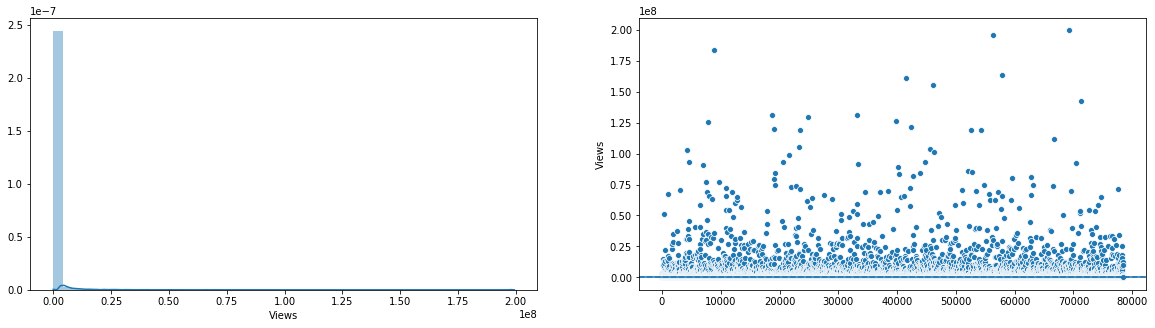

In [21]:
#### Plotting distribution of views

fig,axs = plt.subplots(1,2,figsize = (20,5))
ax = axs[0]
sb.distplot(train['Views'],ax = ax)

ax = axs[1]
mean = train['Views'].mean()
med = train['Views'].median()
sb.scatterplot(x = train.index,y = train['Views'],ax = ax)
ax.axhline(mean,ls = '--')
ax.axhline(med,ls = 'solid')

#### We can see that the target dist is highly right skewed. The mean and median both lie at the lower end. We can try transformations to make it approx normal. 

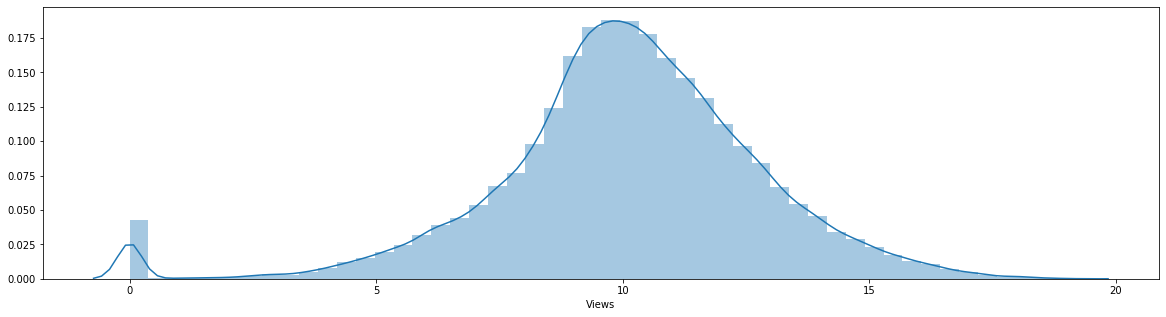

In [22]:
plt.figure(figsize = (20,5))
sb.distplot(np.log(train['Views']+1))
plt.show()

#### Log transformation makes the target distribution approximately normal. 

In [23]:
def print_uniq_(train,test):
  uniq_art_tr = train['Name'].unique().tolist()
  uniq_genre_tr = train['Genre'].unique().tolist()
  uniq_country_tr = train['Country'].unique().tolist()

  uniq_art_test = test['Name'].unique().tolist()
  uniq_genre_test = test['Genre'].unique().tolist()
  uniq_country_test = test['Country'].unique().tolist()

  print('Number of unique artists in train : %s and test : %s' % (len(uniq_art_tr),len(uniq_art_test)))
  print('Number of unique genre in train : %s and test : %s' % (len(uniq_genre_tr),len(uniq_genre_test)))
  print('Number of unique country in train : %s and test : %s' % (len(uniq_country_tr),len(uniq_country_test)))
  
  print('Number of unique artists in train(not in test) : %s and in test(not in train) : %s' % (len(set(uniq_art_tr).difference(set(uniq_art_test))),len(set(uniq_art_test).difference(set(uniq_art_tr)))))
  print('Number of unique genre in train(not in test) : %s and in test(not in train) : %s' % (len(set(uniq_genre_tr).difference(set(uniq_genre_test))),len(set(uniq_genre_test).difference(set(uniq_genre_tr)))))
  print('Number of unique countries in train(not in test) : %s and in test(not in train) : %s' % (len(set(uniq_country_tr).difference(set(uniq_country_test))),len(set(uniq_country_test).difference(set(uniq_country_tr)))))



print_uniq_(train,test)

### Number of unique countries is 1 and hence can be dropped out of dataset. Unique Genre's is same in traina and test. 

train.drop(['Country'],axis = 1,inplace = True)
test.drop(['Country'],axis = 1,inplace = True)

Number of unique artists in train : 1209 and test : 1115
Number of unique genre in train : 21 and test : 21
Number of unique country in train : 1 and test : 1
Number of unique artists in train(not in test) : 104 and in test(not in train) : 10
Number of unique genre in train(not in test) : 0 and in test(not in train) : 0
Number of unique countries in train(not in test) : 0 and in test(not in train) : 0


In [0]:
##### Analyzing the distrubition of views among top artist. Here top 50 artistis are select based on views.
top_artists = train.groupby(['Name'])['Views'].apply(lambda x : sum(x)).sort_values(ascending = False).reset_index()['Name'][:10].values

plt.figure()
sb.countplot(x = train[train['Name'].isin(top_artists.tolist())],y = train['Views'])
plt.show()

In [36]:
top_artists

array(['LIL UZI VERT', 'XXXTENTACION', 'Kodak Black', 'Future',
       '☆LiL PEEP☆', '$UICIDEBOY$', 'octobersveryown',
       'A BOOGIE WIT DA HOODIE', 'Trippie Redd\x7f', 'Juice WRLD',
       'partyomo', 'Major Lazer [OFFICIAL]', 'Post Malone', 'Monstercat',
       'PnB Rock', 'YoungBoy Never Broke Again', '6IX9INE', 'TopDawgEnt',
       'BTS', 'Young Thug', 'Travis Scott', 'Lil Pump', 'Rich The Kid',
       'Lil Yachty, RD, Lil Boat', 'Metro Boomin', '21 Savage',
       'Kevin Gates', 'lil skies', 'FettyWap1738', 'Kygo', 'brysontiller',
       'Diplo', 'Lil Baby', 'R3HAB', 'SKI MASK THE SLUMP GOD',
       'MrSuicideSheep', 'GR6 EXPLODE', 'marshmello', 'Mad Decent',
       'Flume', 'Jacquees', 'Martin Garrix', 'Dj Carnage', 'David Guetta',
       'smokepurpp', 'Tyga', 'Thissongissick.com', 'Pouya .',
       'Tee Grizzley', 'Cardi B'], dtype=object)